In [11]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import TensorDataset, DataLoader


In [12]:

df = pd.read_csv(r"C:\Users\ASUS\OneDrive\Desktop\EXEMPTED\CODED\ML\T1\traffic flow\traffic.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')

values = df['Vehicles'].values

In [13]:
scaler = MinMaxScaler()
values = scaler.fit_transform(values.reshape(-1,1)).flatten()


In [14]:
def create_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+1:i+seq_len+1])
    return np.array(X), np.array(y)

X, y = create_sequences(values, 24)


In [15]:
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [20]:
class LLM_LSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_proj = nn.Linear(1,128)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=8,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)

        self.lstm = nn.LSTM(128,64,batch_first=True)
        self.fc = nn.Linear(64,1)

    def forward(self,x):
        x = self.input_proj(x)
        x = self.transformer(x)
        x,_ = self.lstm(x)
        return self.fc(x)


In [21]:
model = LLM_LSTM()


In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.MSELoss()

for epoch in range(40):
    total_loss = 0
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print("Epoch",epoch+1,"Loss",total_loss)


Epoch 1 Loss 14.29819230735302
Epoch 2 Loss 12.470494182780385
Epoch 3 Loss 12.217429456766695
Epoch 4 Loss 12.024391163606197
Epoch 5 Loss 11.864645888097584
Epoch 6 Loss 11.737857016501948
Epoch 7 Loss 11.602070125751197
Epoch 8 Loss 11.461790690664202
Epoch 9 Loss 11.33392202667892
Epoch 10 Loss 11.18293194938451
Epoch 11 Loss 11.05210031894967
Epoch 12 Loss 10.876540646422654
Epoch 13 Loss 10.702041879994795
Epoch 14 Loss 10.52578323544003
Epoch 15 Loss 10.348937386181206
Epoch 16 Loss 10.1282901072409
Epoch 17 Loss 9.936754310969263
Epoch 18 Loss 9.75745344767347
Epoch 19 Loss 9.540479256538674
Epoch 20 Loss 9.349747283849865
Epoch 21 Loss 9.195295985322446
Epoch 22 Loss 9.002520391019061
Epoch 23 Loss 8.810810247203335
Epoch 24 Loss 8.656262448523194
Epoch 25 Loss 8.498570226831362
Epoch 26 Loss 8.331830920651555
Epoch 27 Loss 8.174391778651625
Epoch 28 Loss 8.014651679899544
Epoch 29 Loss 7.885230995249003
Epoch 30 Loss 7.737189328065142
Epoch 31 Loss 7.616270038066432
Epoch 32 

In [23]:
model.eval()
preds, actual = [], []

with torch.no_grad():
    for batch_x, batch_y in loader:
        out = model(batch_x)
        preds.append(out.numpy())
        actual.append(batch_y.numpy())

preds = np.concatenate(preds)
actual = np.concatenate(actual)

preds = scaler.inverse_transform(preds.reshape(-1,1)).flatten()
actual = scaler.inverse_transform(actual.reshape(-1,1)).flatten()

mae = mean_absolute_error(actual,preds)
rmse = np.sqrt(mean_squared_error(actual,preds))

print("MAE:",mae)
print("RMSE:",rmse)


MAE: 7.975398063659668
RMSE: 11.082077720095555


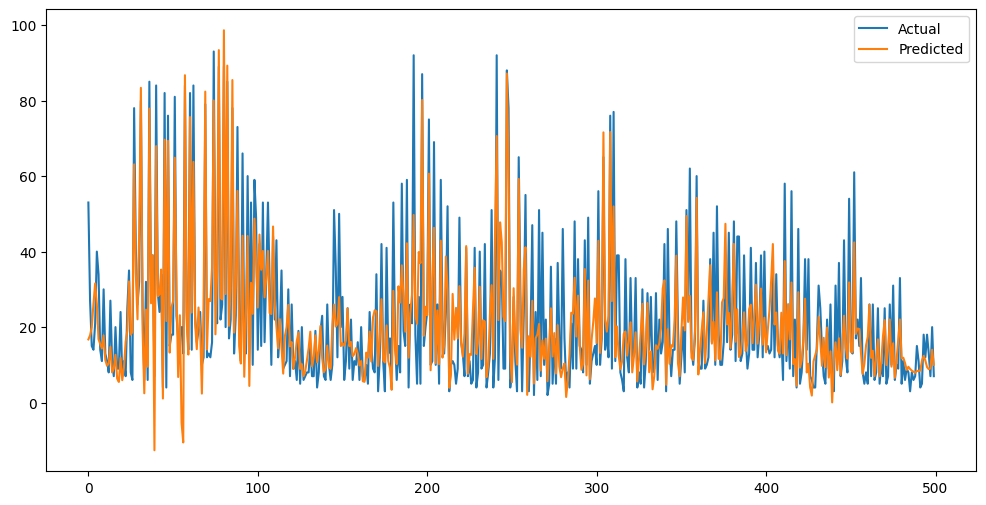

In [24]:
plt.figure(figsize=(12,6))
plt.plot(actual[:500],label="Actual")
plt.plot(preds[:500],label="Predicted")
plt.legend()
plt.show()


In [25]:
print(model)

LLM_LSTM(
  (input_proj): Linear(in_features=1, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (lstm): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [16]:
class LLM_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_proj = nn.Linear(1,128)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=8,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)

        self.conv = nn.Conv1d(128,64,kernel_size=3,padding=1)
        self.relu = nn.ReLU()

        self.fc = nn.Linear(64,1)

    def forward(self,x):
        x = self.input_proj(x)
        x = self.transformer(x)

        x = x.permute(0,2,1)
        x = self.relu(self.conv(x))
        x = x.permute(0,2,1)

        return self.fc(x)


In [17]:
model = LLM_CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.MSELoss()


In [18]:
for epoch in range(40):
    total_loss = 0

    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print("Epoch", epoch+1, "Loss", total_loss)


Epoch 1 Loss 2.5258971162547823
Epoch 2 Loss 0.8088301561801927
Epoch 3 Loss 0.7626754472439643
Epoch 4 Loss 0.7394522261747625
Epoch 5 Loss 0.7245877377572469
Epoch 6 Loss 0.7125290265466901
Epoch 7 Loss 0.7009324824030045
Epoch 8 Loss 0.694215425683069
Epoch 9 Loss 0.68504021615081
Epoch 10 Loss 0.6808264127903385
Epoch 11 Loss 0.6735307703493163
Epoch 12 Loss 0.6706166868534638
Epoch 13 Loss 0.665526768338168
Epoch 14 Loss 0.6634806831352762
Epoch 15 Loss 0.6589268727620947
Epoch 16 Loss 0.6558408385462826
Epoch 17 Loss 0.6555205273471074
Epoch 18 Loss 0.6496384184574708
Epoch 19 Loss 0.6494046551233623
Epoch 20 Loss 0.6469797681129421
Epoch 21 Loss 0.6460634512404795
Epoch 22 Loss 0.645287438055675
Epoch 23 Loss 0.6418370606188546
Epoch 24 Loss 0.6395816391086555
Epoch 25 Loss 0.6385676584250177
Epoch 26 Loss 0.634967612233595
Epoch 27 Loss 0.6358320924191503
Epoch 28 Loss 0.633740468074393
Epoch 29 Loss 0.6334732353570871
Epoch 30 Loss 0.6319618584093405
Epoch 31 Loss 0.6312279338

In [19]:
model.eval()
preds, actual = [], []

with torch.no_grad():
    for batch_x, batch_y in loader:
        out = model(batch_x)
        preds.append(out.numpy())
        actual.append(batch_y.numpy())

preds = np.concatenate(preds)
actual = np.concatenate(actual)

preds = scaler.inverse_transform(preds.reshape(-1,1)).flatten()
actual = scaler.inverse_transform(actual.reshape(-1,1)).flatten()

mae = mean_absolute_error(actual, preds)
rmse = np.sqrt(mean_squared_error(actual, preds))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 0.9963650107383728
RMSE: 3.663466415232588


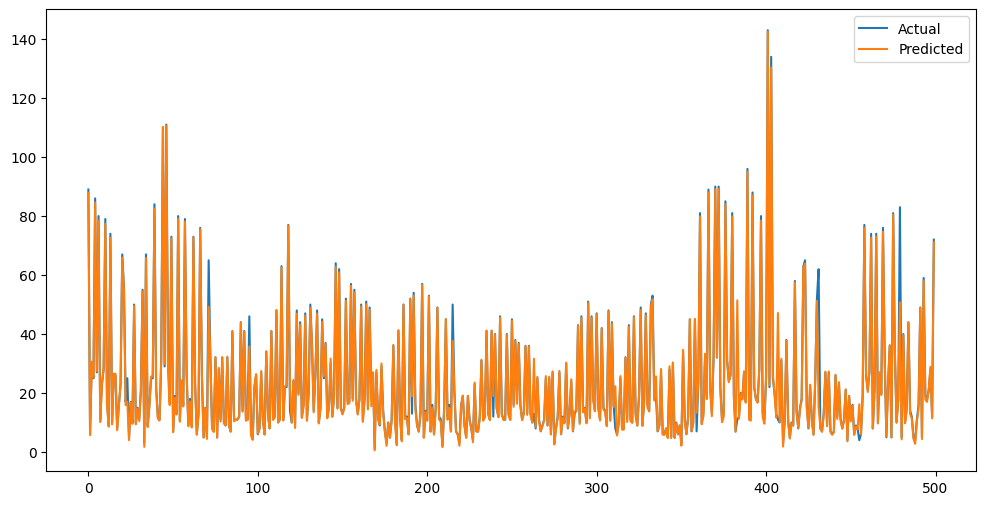

In [20]:
plt.figure(figsize=(12,6))
plt.plot(actual[:500], label="Actual")
plt.plot(preds[:500], label="Predicted")
plt.legend()
plt.show()


In [21]:
import torch.nn as nn

class LLM_GRU(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_proj = nn.Linear(1, 128)     # project traffic value into embedding

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=8,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        # transformer extracts long-range temporal features

        self.gru = nn.GRU(128, 64, batch_first=True)
        # GRU captures sequential dependencies

        self.fc = nn.Linear(64, 1)              # final prediction layer

    def forward(self, x):
        x = self.input_proj(x)
        x = self.transformer(x)
        x, _ = self.gru(x)
        return self.fc(x)


In [22]:
model = LLM_GRU()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.MSELoss()


In [23]:
for epoch in range(40):
    total_loss = 0

    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print("Epoch", epoch+1, "Loss", total_loss)


Epoch 1 Loss 15.844469415489584
Epoch 2 Loss 12.682278694119304
Epoch 3 Loss 12.426883732667193
Epoch 4 Loss 12.226415634155273
Epoch 5 Loss 12.05488939397037
Epoch 6 Loss 11.94820723310113
Epoch 7 Loss 11.843747380655259
Epoch 8 Loss 11.753543914761394
Epoch 9 Loss 11.665673656389117
Epoch 10 Loss 11.595726969651878
Epoch 11 Loss 11.50256913062185
Epoch 12 Loss 11.442215766757727
Epoch 13 Loss 11.341694721020758
Epoch 14 Loss 11.29286979092285
Epoch 15 Loss 11.191058759810403
Epoch 16 Loss 11.126994213322178
Epoch 17 Loss 11.016537389252335
Epoch 18 Loss 10.932391467504203
Epoch 19 Loss 10.81867249077186
Epoch 20 Loss 10.709451614646241
Epoch 21 Loss 10.59631350217387
Epoch 22 Loss 10.485776877962053
Epoch 23 Loss 10.388604383682832
Epoch 24 Loss 10.261922309175134
Epoch 25 Loss 10.148416910786182
Epoch 26 Loss 10.025128833949566
Epoch 27 Loss 9.911615772172809
Epoch 28 Loss 9.764439523685724
Epoch 29 Loss 9.66902025626041
Epoch 30 Loss 9.53086283779703
Epoch 31 Loss 9.41540558100678


In [24]:
model.eval()                           # set model to evaluation mode

preds = []
actual = []

with torch.no_grad():                  # disable gradient computation
    for batch_x, batch_y in loader:
        output = model(batch_x)        # model prediction
        preds.append(output.numpy())   # store predicted values
        actual.append(batch_y.numpy()) # store actual values


In [25]:
import numpy as np

preds = np.concatenate(preds)          # combine batches
actual = np.concatenate(actual)


In [26]:
preds = scaler.inverse_transform(preds.reshape(-1,1)).flatten()
actual = scaler.inverse_transform(actual.reshape(-1,1)).flatten()


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actual, preds)
rmse = np.sqrt(mean_squared_error(actual, preds))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 9.332399368286133
RMSE: 12.816789606808536


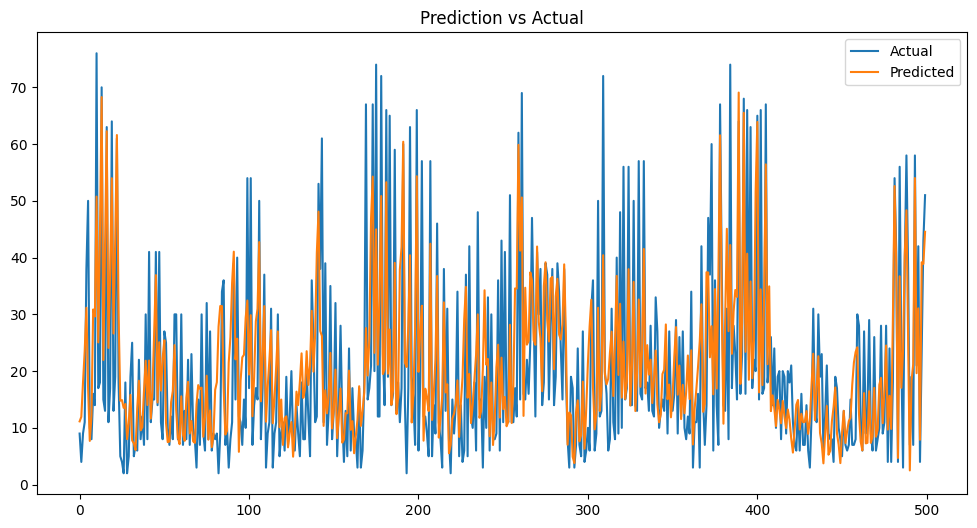

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(actual[:500], label="Actual")
plt.plot(preds[:500], label="Predicted")
plt.title("Prediction vs Actual")
plt.legend()
plt.show()
